In [1]:
import os

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False

In [2]:
from ESG.config import TEST_DATA_DIR, RAW_DATA_DIR, FIGURE_DIR, RESULT_DIR
from utils.data_porter import save_to_csv

In [3]:
zz_stock_df = pd.read_csv(os.path.join(RAW_DATA_DIR, 'stock300_500.csv'))
score_df = pd.read_csv(os.path.join(TEST_DATA_DIR, 'esg_score_202012.csv'))
total_score_df = score_df
zz_score_df = pd.merge(zz_stock_df, score_df, how='left', on='STOCK_CODE')

In [4]:
def get_params_df_bars(df, group_by, bins=10, **kwargs):
    if type(df) == list:
        dfs = df
        groups = group_by
    elif not group_by:
        dfs = [df]
        groups = ['total',]
    else:
        groups = df.groupby(by=group_by).groups
        dfs = [df.iloc[groups[i]] for i in groups]
    return np.array([plt.hist(df['ESG_SCORE'], bins=bins, **kwargs)[0] for df in dfs]), [i for i in groups]

In [5]:
def plot_bars(freq, groups, fname):
    n_dfs = freq.shape[0]
    n_bins = freq.shape[1]
    width = 1 / (1 + n_dfs)
    for i in range(n_dfs):
        plt.bar((width * i + np.arange(n_bins) + .3)/10, freq[i] * 10., width=width/10, label=groups[i])
    plt.title(fname)
    plt.legend()
    plt.xticks([.1, .3, .5, .7, .9])
    plt.xlabel('ESG评分')
    plt.ylabel('整体占比(%)')
    plt.savefig(os.path.join(FIGURE_DIR, fname+'.png'))

下图及相似图像均无实际意义，仅为程序中间结果所作。

C:\Users\10915\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


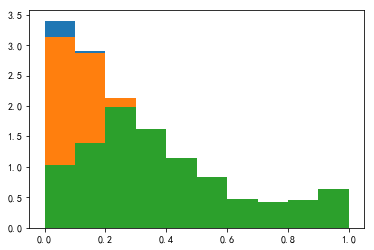

In [6]:
total_params = get_params_df_bars(total_score_df, group_by=['REPORT_YEAR'], normed=True)

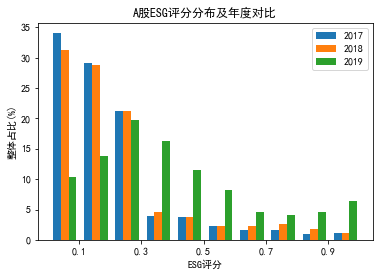

In [7]:
plot_bars(*total_params, 'A股ESG评分分布及年度对比')

ESG评分均为0-1之间，上图中横轴代表ESG评分，分别以0.1为间隔分为10组，纵轴代表对应ESG得分股票在整体中的占比。

我们可以发现，2017及2018年,A股整体ESG评分偏低，仅有约20%ESG评分高于0.3且从2017至2018年ESG评分提升并不明显，得分为0.9以上的企业并未增加。

2019年，ESG评分呈现大幅上涨，A股中ESG评分在0.2以下的占比大幅减少，并有约50%ESG得分位于0.2-0.6之间。同时，ESG得分>0.6的领先企业
相比于2018年增长了一倍。

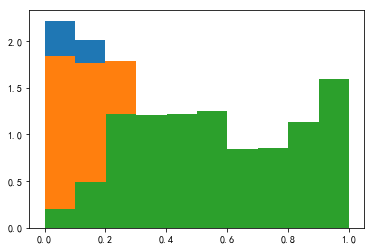

In [8]:
zz_params = get_params_df_bars(zz_score_df, group_by=['REPORT_YEAR'], normed=True)

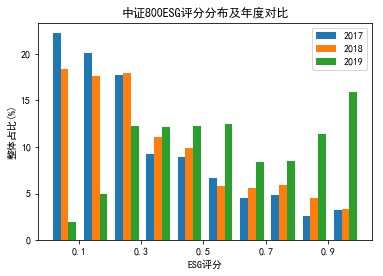

In [9]:
plot_bars(*zz_params, '中证800ESG评分分布及年度对比')

相比于整体A股，中证800ESG得分普遍较高，2017年便有40%ESG得分高于0.3，是同期A股的两倍。
然而， 2017-2018年间，中证800ESG得分同样没有表现出明显上涨。

2019年，中证800ESG评分也呈现大幅上涨，ESG评分在0.2以下的占比大幅减少，约为7%。
同时约50%ESG得分位于0.2-0.6之间。同时，ESG得分>0.9的领先企业从2018年的4%上升到了17%。

C:\Users\10915\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


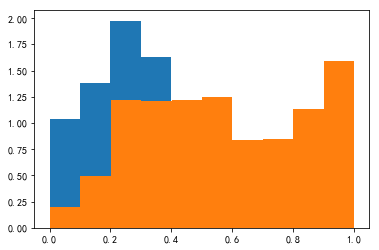

In [10]:
compare_params = get_params_df_bars([total_score_df[total_score_df['REPORT_YEAR']==2019],
                                     zz_score_df[zz_score_df['REPORT_YEAR']==2019]], group_by=['A股', '中证800'], normed=True)

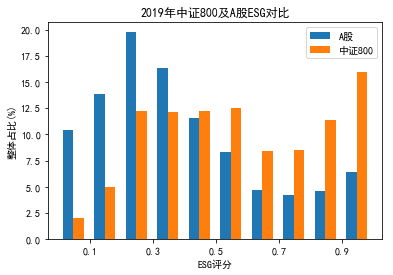

In [11]:
plot_bars(*compare_params, '2019年中证800及A股ESG对比')

2019年，中证800较A股ESG表现更优，在ESG评分领先企业中占比显著高于A股。

In [12]:
def industry_esg_overview(df):
    grouped = df.groupby(by=['INDUSTRY', 'REPORT_YEAR'])['ESG_SCORE']
    cols = ['observations', 'max', 'min', 'mean', 'median', 'std.', 'increase%']
    obs_df = grouped.apply(len)
    max_df = grouped.apply(np.max)
    min_df = grouped.apply(np.min)
    mean_df = grouped.apply(np.mean)
    median_df = grouped.apply(np.median)
    std_df = grouped.apply(np.std)
    increase_percent = [(mean_df.values[i] / mean_df.values[i-1] - 1) * 100. 
                        if i % 3 != 0 else np.nan for i in range(mean_df.shape[0])]
    overview_df = pd.DataFrame(np.array([obs_df.values, 
                                         max_df.values, 
                                         min_df.values, 
                                         mean_df.values, 
                                         median_df.values, 
                                         std_df.values,
                                         increase_percent]).T,
                               columns=cols,
                               index=obs_df.index)
    overview_df['observations'] = pd.Series(overview_df['observations'], dtype='int32')
    return overview_df

In [13]:
zz_industry_overview = industry_esg_overview(zz_score_df)
save_to_csv(zz_industry_overview, RESULT_DIR, fname='中证800行业年度ESG基本信息', index=True)

In [14]:
total_industry_overview = industry_esg_overview(total_score_df)
save_to_csv(total_industry_overview, RESULT_DIR, fname='A股行业年度ESG基本信息', index=True)

In [15]:
def boxplots_compare():
    pass

In [16]:
year = 2019
total_2019_df = total_score_df[total_score_df['REPORT_YEAR'] == year].reset_index(drop=True)
zz_2019_df = zz_score_df[zz_score_df['REPORT_YEAR']==year].reset_index(drop=True)

In [17]:
total_2019_groups = total_2019_df.groupby(by=['INDUSTRY']).groups
total_2019_esg = [total_2019_df.iloc[total_2019_groups[i]]['ESG_SCORE'].values for i in total_2019_groups]

zz_2019_groups = zz_2019_df.groupby(by=['INDUSTRY']).groups
zz_2019_esg = [zz_2019_df.iloc[zz_2019_groups[i]]['ESG_SCORE'].values for i in zz_2019_groups]

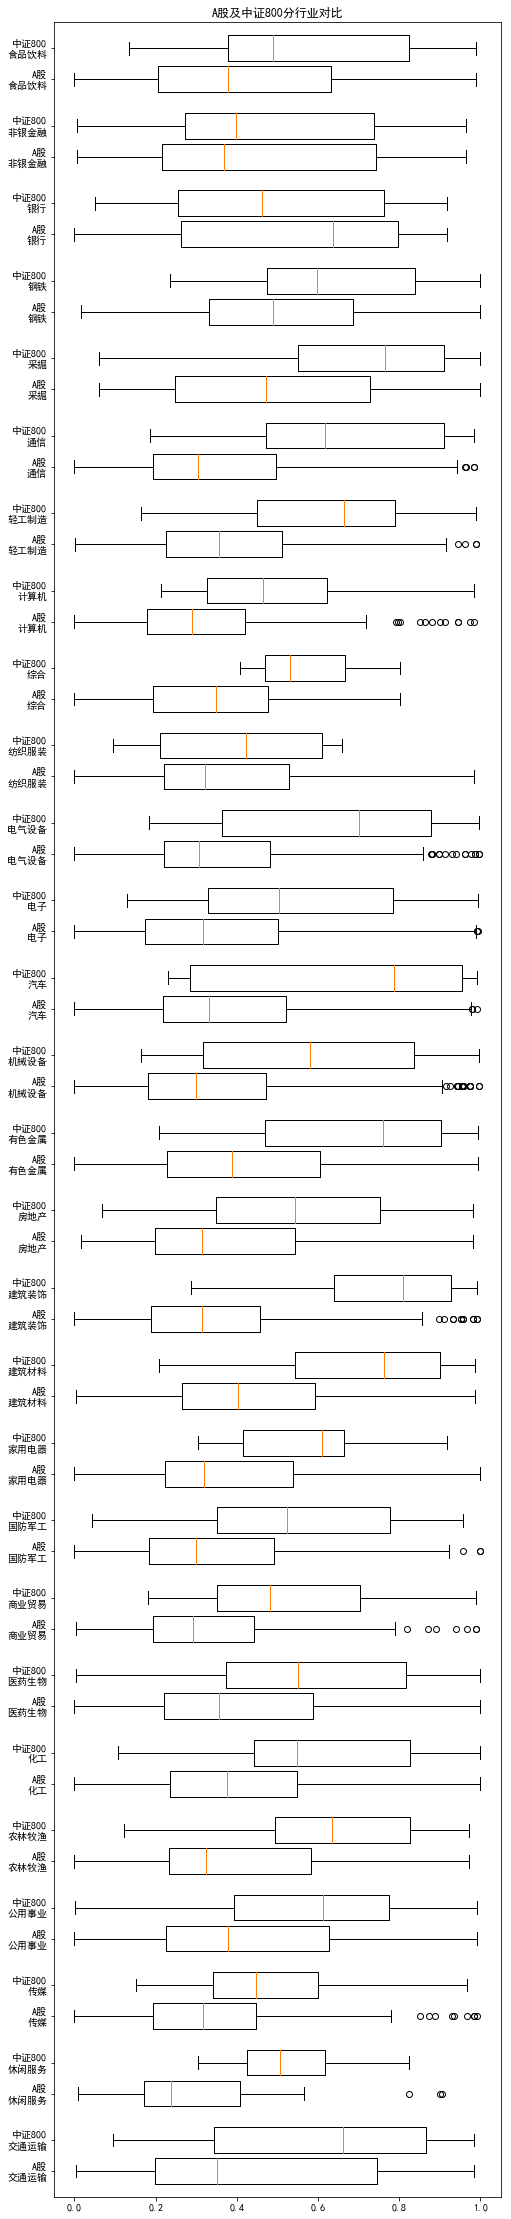

In [18]:
comp_data = list()
pos = list()
labels = list()
for i, l in enumerate(total_2019_groups):
    comp_data.append(total_2019_esg[i])
    comp_data.append(zz_2019_esg[i])
    pos.append(1.5 * i)
    pos.append(1.5 * i + .6)
    labels.append('A股\n' + l)
    labels.append('中证800\n' + l)
    
fig, ax = plt.subplots(figsize=(8, 40))
ax.boxplot(comp_data, positions = pos, vert=False)
ax.set_yticklabels(labels)
plt.title('A股及中证800分行业对比')
plt.savefig(os.path.join(FIGURE_DIR, 'A股及中证800分行业对比.png'))

2019年，中证800ESG评分明显高于A股，下面是一些值得注意的异常：
* 中证800中银行业ESG评分非明显高于A股银行业，同时ESG中位数较A股更低。
* 在通信，综合，建筑装饰，建筑材料以及休闲服务行业中，中证800ESG评分均大幅超过A股平均水平。
* 食品饮料，钢铁，采掘，轻工制造，计算机，电气设备，电子，汽车，机械设备，有色金属，房地产，
家用电器，国防军工，商业贸易，医药生物，化工，农林牧渔，公共事业，传媒，交通运输行业ESG评分明显高于A股。
* 中证800ESG评分分散程度（四分位间距）大致与A股相近：
    * 在通信，电气设备，电子，汽车，机械设备、商业贸易中，中证800ESG评分明显更为分散。

In [22]:
import statsmodels as sm
from scipy import stats

results = dict()
for ind in total_2019_groups:
    results[ind] = stats.mannwhitneyu(total_2019_df[total_2019_df['INDUSTRY'] == ind]['ESG_SCORE'], 
                                      total_2019_df[total_2019_df['INDUSTRY'] != ind]['ESG_SCORE'], 
                                      alternative='two-sided')

In [25]:
a = results['交通运输'].pvalue

In [30]:
stats.mannwhitneyu(range(10000), -np.arange(10000))

MannwhitneyuResult(statistic=0.5, pvalue=0.0)